In [1]:
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt
from transformers import AutoTokenizer
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [2]:
df = pd.read_pickle('pipeline/normalized_data/webnlg_raw.pkl')


df['lex_char_len'] = df.nl.map(lambda x: " ".join(x)).str.len()
df['rdf_char_len'] = df.sd.map(lambda x: " ".join(x)).str.len()

In [3]:
df.describe().round(2)

,index,lex_char_len,rdf_char_len
count,16095.00,16095.00,16095.00
mean,5310.86,310.68,139.54
std,4021.72,171.69,83.79
min,0.00,22.00,22.00
25%,1341.00,174.00,71.00
50%,4828.00,291.00,130.00
75%,8851.50,421.00,190.00
max,12875.00,1191.00,657.00


In [4]:
print(
    df.category.value_counts().to_latex()
)

\begin{tabular}{lr}
\toprule
{} &  category \\
\midrule
Food                 &      1766 \\
Artist               &      1528 \\
Politician           &      1493 \\
MeanOfTransportation &      1416 \\
City                 &      1386 \\
Airport              &      1356 \\
Building             &      1215 \\
WrittenWork          &      1171 \\
Athlete              &      1129 \\
SportsTeam           &       983 \\
CelestialBody        &       792 \\
Astronaut            &       663 \\
University           &       508 \\
ComicsCharacter      &       357 \\
Monument             &       332 \\
\bottomrule
\end{tabular}



<ipython-input-4-003a24d353ea>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.category.value_counts().to_latex()


 country                  1210
 location                 1040
 isPartOf                  642
 club                      578
 genre                     513
                          ... 
 languages                   1
 draftPick                   1
 nearestCity                 1
 currentteam                 1
 has to its northwest        1
Name: sd, Length: 373, dtype: int64

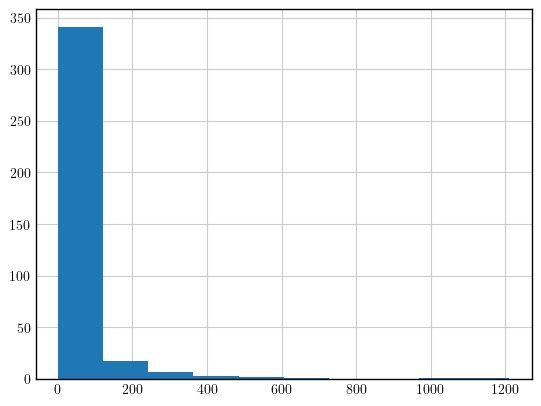

In [5]:
label_dist = df.sd.map(lambda x: ";".join(x)).map(_.split("|")).map(get[1])
label_dist.value_counts().hist()
label_dist.value_counts()

In [6]:
counts_alone = label_dist.value_counts().values

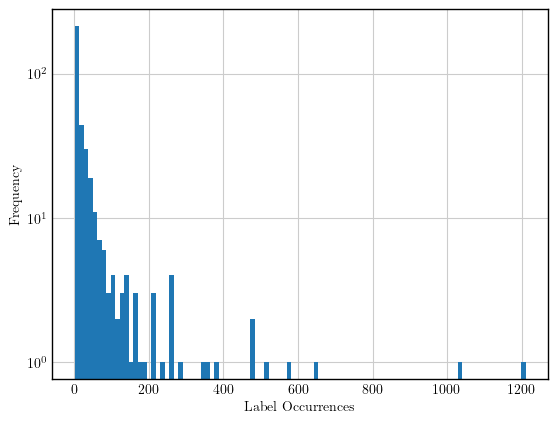

In [7]:
# Function x**(1/2)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2
ax = plt.hist(counts_alone, bins=100, density=False)
plt.xlabel('Label Occurrences')
plt.ylabel('Frequency')
# plt.xscale('function', functions=(np.exp, np.log))
# plt.yscale('function', functions=(np.exp, np.log))
plt.yscale('log')
# ax.set_yscale('function', functions=(forward, inverse))

# ax.set_xlim([1, 180])

In [8]:
wb = pd.read_pickle("~/repos/nlgs-research/pipeline/normalized_data/wikibio.pkl").sample(8000)
wb['char_len'] = wb.target_text.str.len()
wb.target_text = (
    wb.target_text
    .str.replace("-lrb- ", "(")
    .str.replace(" -rrb-", ")")
    .str.replace(" ,", ",")
)
wb.target_text 

236978    kamal abbas (-rrb- is general coordinator of t...
707656    ronald manning fielding (october 7, 1896 -- ma...
715716    petr drobisz (born 14 july 1976 is a czech foo...
583736    minnie lichtenstein was born in dallas in 1882...
401943    wang anshun (; born december 1957) is a politi...
                                ...                        
517752    susan hyatt is an american singer, songwriter,...
70214     ian anthony pearce (born 7 may 1974 in bury st...
453624    timea sara (born april 21, 1992) is a romanian...
471090    john cameron henry, jr. (born november 1, 1974...
365882    victoria jane nuland (born 1961) is the assist...
Name: target_text, Length: 8000, dtype: object

In [9]:
wb.describe().round(2)

print(wb[wb.char_len > 100][wb.char_len < 500].iloc[-1].target_text)
wb[wb.char_len > 100][wb.char_len < 500]

victoria jane nuland (born 1961) is the assistant secretary of state for european and eurasian affairs at the united states department of state .



<ipython-input-9-582d50e7cc41>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(wb[wb.char_len > 100][wb.char_len < 500].iloc[-1].target_text)
<ipython-input-9-582d50e7cc41>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wb[wb.char_len > 100][wb.char_len < 500]


,subset,target_text,char_len
715716,test,petr drobisz (born 14 july 1976 is a czech foo...,443
401943,train,wang anshun (; born december 1957) is a politi...,255
374804,train,"enrico aldo candiani (born september 30, 1918 ...",164
64856,val,"artavasdos or artabasdos (or, from armenian : ...",355
547758,train,andy green is an american former darts player ...,287
...,...,...,...
170912,train,marcus böhme (born 25 august 1985) is a german...,310
517752,train,"susan hyatt is an american singer, songwriter,...",259
453624,train,"timea sara (born april 21, 1992) is a romanian...",171
471090,train,"john cameron henry, jr. (born november 1, 1974...",299


In [10]:
from evaluate import load

bertscore = load('bertscore')
compute_bert = lambda x,y: bertscore.compute(predictions=[y], references=[x], lang="en", model_type="distilbert-base-uncased" )

In [11]:
preds = pd.read_pickle("~/repos/nlgs-research/pipeline/predictions/mt-t5-base-5.pkl")
scores = pd.read_pickle("~/repos/nlgs-research/pipeline/scores/mt-t5-base-5/d2s_scores.pkl")
scores

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,100.000000,"[23, 22, 21, 20]","[23, 22, 21, 20]","[100.0, 100.0, 100.0, 100.0]",1.000000,23,23,1.000000,1.000000,1.000000,1.000000
2,0.965428,0.955821,0.960601,58.088877,"[13, 10, 7, 4]","[14, 13, 12, 11]","[92.85714285714286, 76.92307692307692, 58.3333...",0.931063,14,15,0.869565,0.666667,0.608696,0.608696
3,0.967089,0.967089,0.967089,83.445229,"[12, 10, 8, 6]","[12, 11, 10, 9]","[100.0, 90.9090909090909, 80.0, 66.66666666666...",1.000000,12,12,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.908319,0.928685,0.914608,65.665186,"[60, 49, 41, 32]","[66, 65, 64, 63]","[90.9090909090909, 75.38461538461539, 64.0625,...",0.955563,66,69,0.800000,0.601626,0.553571,0.553571
1596,0.906706,0.911675,0.909184,55.618572,"[47, 37, 28, 23]","[60, 59, 58, 57]","[78.33333333333333, 62.71186440677966, 48.2758...",1.000000,60,55,0.836735,0.645833,0.530612,0.530612
1597,0.953073,0.969660,0.961295,58.535241,"[48, 35, 28, 22]","[56, 55, 54, 53]","[85.71428571428571, 63.63636363636363, 51.8518...",1.000000,56,49,0.869565,0.637363,0.666667,0.666667
1598,0.919989,0.944636,0.924725,55.746829,"[54, 40, 28, 20]","[61, 60, 59, 58]","[88.52459016393442, 66.66666666666667, 47.4576...",1.000000,61,58,0.846847,0.587156,0.653846,0.653846


<ipython-input-12-e249244acbff>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')
<ipython-input-12-e249244acbff>:19: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.723343733224719, pvalue=2.582954574384578e-259)

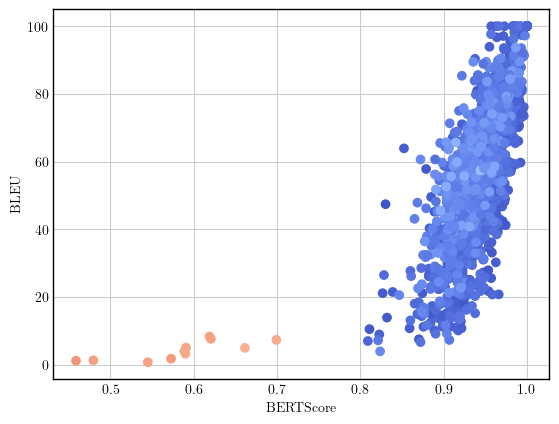

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

X = scores.bert_f1
Y = scores.bleu_score
Z = scores.bleu_sys_len


fig = plt.figure()

cmap = cm.get_cmap('coolwarm')
color = cmap(Z)[..., :3]

ax = plt.scatter(X,Y,c=color)
plt.xlabel('BERTScore')
plt.ylabel('BLEU')
from scipy.stats.stats import pearsonr   
pearsonr(X, Y)

PearsonRResult(statistic=-0.6616201436829712, pvalue=4.766404904314674e-202)

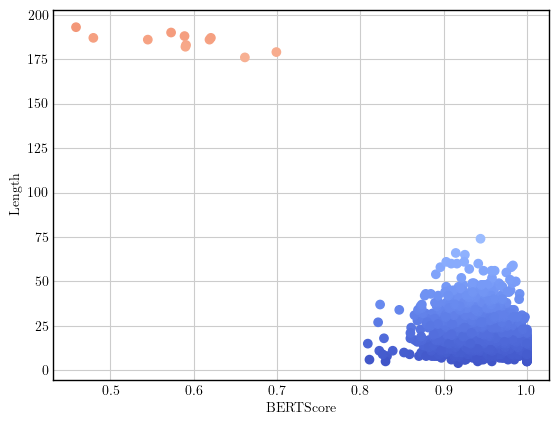

In [13]:
ax = plt.scatter(X,Z,c=color)
plt.xlabel('BERTScore')
plt.ylabel('Length')
pearsonr(X,Z)